In [2]:
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import numpy as np

In [3]:
tsla = yf.Ticker('TSLA')
tsla_data = tsla.history(period='5y')
tsla_data.reset_index(inplace=True)
tsla_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-11-30,20.570667,20.713333,20.302668,20.590000,65274000,0,0.0
1,2017-12-01,20.362667,20.688000,20.336666,20.435333,64393500,0,0.0
2,2017-12-04,20.433332,20.551332,20.040667,20.346666,87526500,0,0.0
3,2017-12-05,20.133333,20.533333,20.066668,20.246668,69697500,0,0.0
4,2017-12-06,20.006666,20.892668,20.000000,20.884001,107929500,0,0.0


Text(0, 0.5, 'Prices ($)')

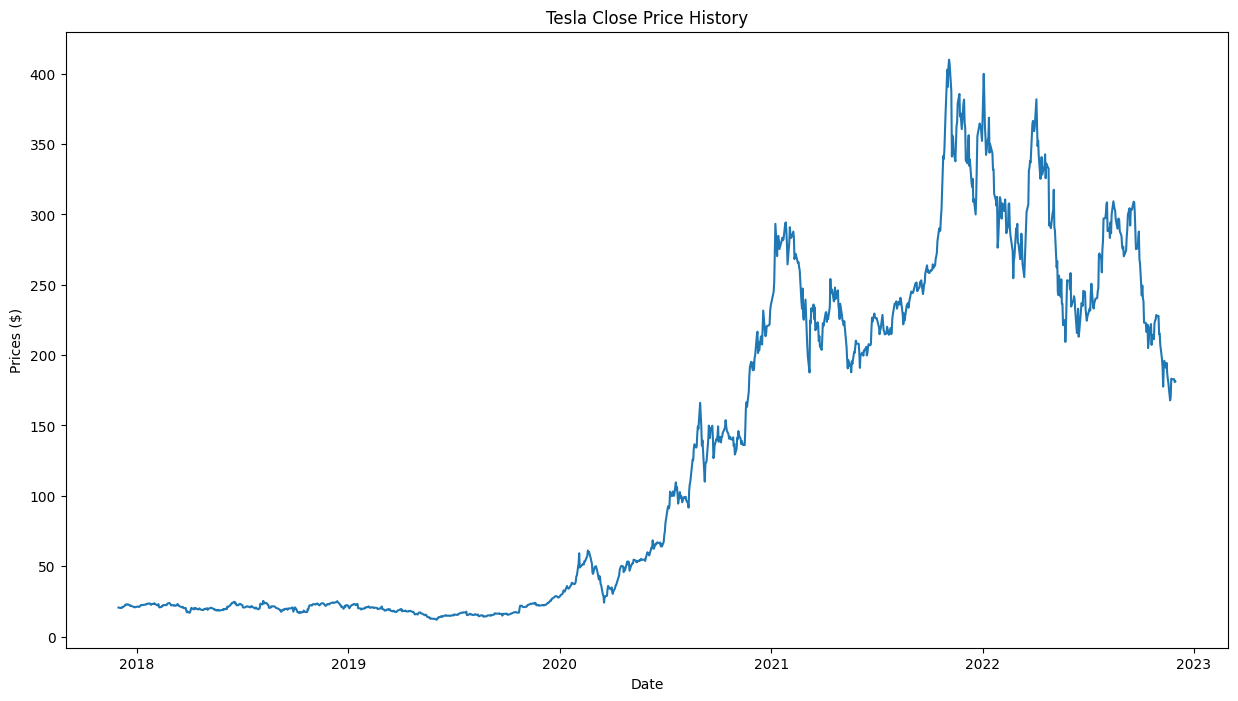

In [4]:
plt.figure(figsize=(15, 8))
plt.title('Tesla Close Price History')
plt.plot(tsla_data['Date'],tsla_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [5]:
close_data = tsla_data.iloc[:,4].values.reshape(-1,1)
# volume_data = tsla_data.iloc[:,5].values.reshape(-1,1)
# open_data = tsla_data.iloc[:,1].values.reshape(-1,1)
#extract the Close Price and The volume for that day

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

scaled_close = scaler.fit_transform(close_data)


# scaled_volume = scaler.fit_transform(volume_data)
# scaled_open = scaler.fit_transform(open_data)

In [7]:
scaled_data = []

for i in range(0,len(scaled_close)):
    # scaled_data.append([scaled_close[i],scaled_open[i],scaled_volume[i]])
    scaled_data.append(scaled_close[i])

scaled_data = np.array(scaled_data).squeeze()

In [8]:
scaled_data.shape

(1259,)

In [9]:
train_split = .7
train_data = scaled_data[0:int(train_split*len(scaled_data))]
train_data_len = len(train_data)


In [10]:
input_vector_length = 50

x_train = []
y_train = []

for i in range(input_vector_length,len(train_data)):
    x_train.append(train_data[i-input_vector_length:i])
    # y_train.append(train_data[i,0]) ## add the 0 here to chop off the volume, only want the volume as input
    y_train.append(train_data[i])

x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
x_train.shape, y_train.shape

((831, 50), (831,))

In [12]:
# test_data = scaled_data[int(train_split*len(scaled_data)) - input_vector_length: , :]
test_data = scaled_data[int(train_split*len(scaled_data)) - input_vector_length:]

test_data_len = len(test_data)
x_test = []
# y_test = test_data[input_vector_length:,0]
y_test = test_data[input_vector_length:]

for i in range(input_vector_length,len(test_data)):
    x_test.append(test_data[i-input_vector_length:i])

x_test = np.array(x_test)

In [13]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(831, 50) (831,)
(378, 50) (378,)


In [14]:
import keras
from keras import layers

In [15]:
model = keras.Sequential()

model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(layers.LSTM(100, return_sequences = False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',loss = 'mean_squared_error')
model.fit(x_train,y_train, batch_size = 1, epochs = 10)

Epoch 1/10
831/831 [==============================] - 19s 19ms/step - loss: 0.0019
Epoch 2/10
831/831 [==============================] - 17s 20ms/step - loss: 8.3147e-04
Epoch 3/10
831/831 [==============================] - 16s 19ms/step - loss: 6.0161e-04
Epoch 4/10
831/831 [==============================] - 15s 18ms/step - loss: 6.0027e-04
Epoch 5/10
831/831 [==============================] - 15s 17ms/step - loss: 5.3403e-04
Epoch 6/10
831/831 [==============================] - 15s 18ms/step - loss: 4.1844e-04
Epoch 7/10
831/831 [==============================] - 15s 18ms/step - loss: 5.8376e-04
Epoch 8/10
831/831 [==============================] - 15s 19ms/step - loss: 3.0476e-04
Epoch 9/10
831/831 [==============================] - 16s 19ms/step - loss: 3.6122e-04
Epoch 10/10
831/831 [==============================] - 15s 18ms/step - loss: 5.5498e-04


In [17]:
test_predictions = model.predict(x_test)
train_predictions = model.predict(x_train)
test_predictions = scaler.inverse_transform(test_predictions)
train_predictions = scaler.inverse_transform(train_predictions)
rmse = np.sqrt(np.mean(test_predictions - y_test)**2)
rmse

269.6784878113645

C:\Users\dksil\AppData\Local\Temp\ipykernel_13800\519884937.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = test_predictions


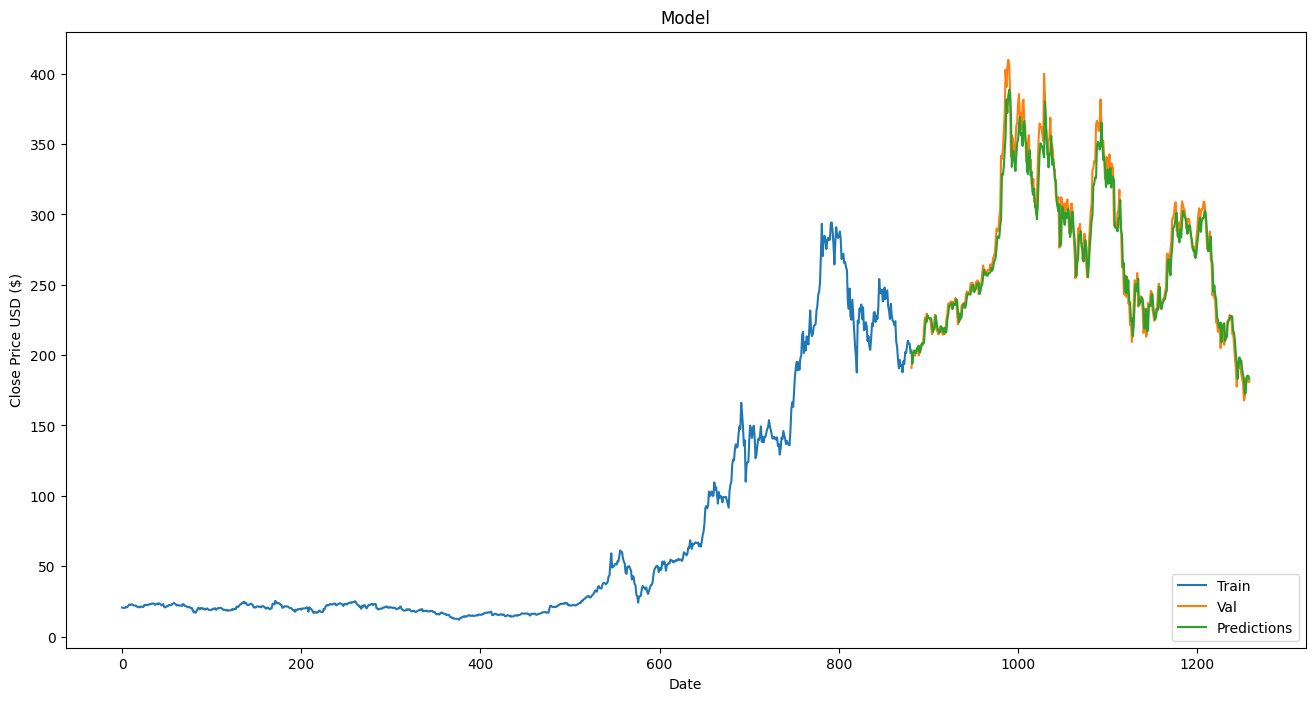

In [18]:
data = tsla_data.filter(['Close'])
train = data[:train_data_len]
validation = data[train_data_len:]
validation['Predictions'] = test_predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

C:\Users\dksil\AppData\Local\Temp\ipykernel_13800\3238405931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = test_predictions


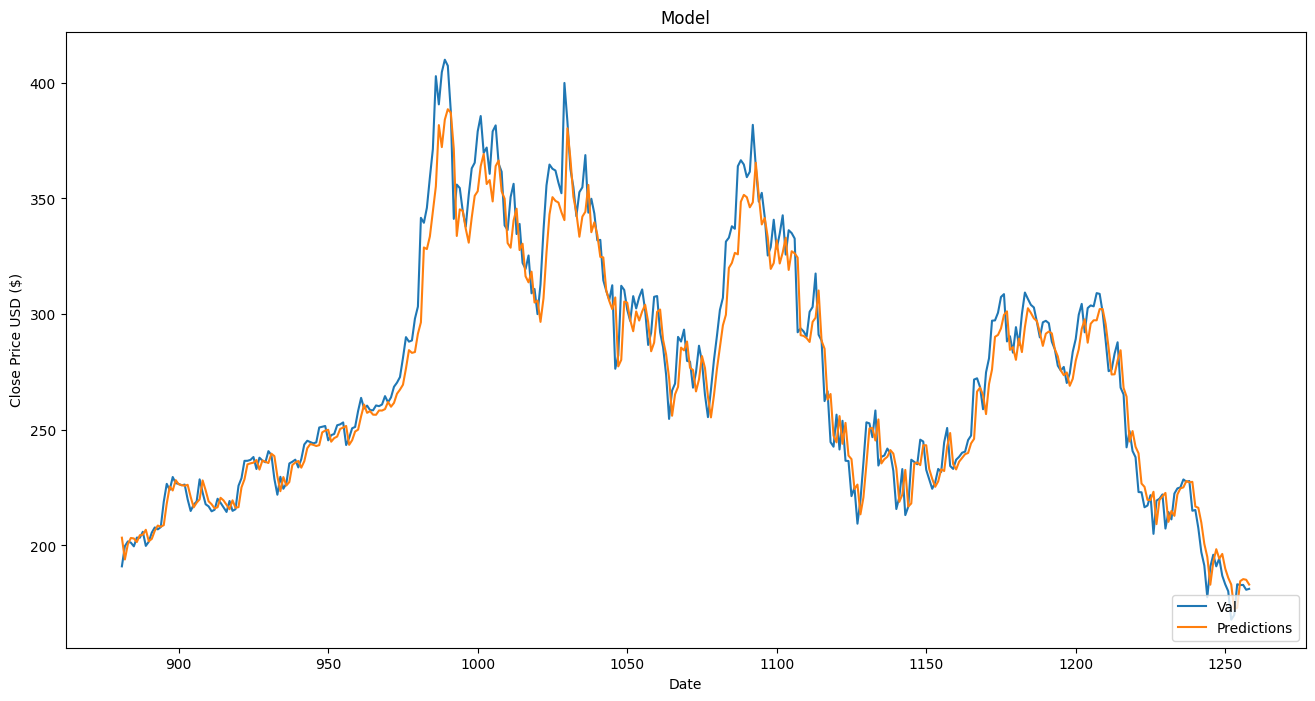

In [19]:
data = tsla_data.filter(['Close'])
validation = data[train_data_len:]
validation['Predictions'] = test_predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()